In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

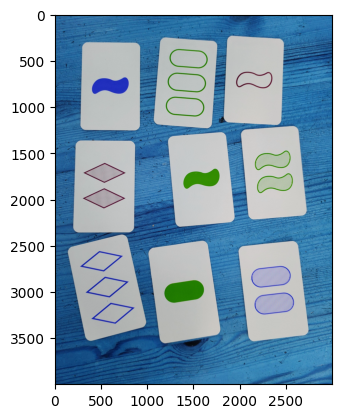

In [48]:
img = cv2.imread("../uploads/raw_image.png")
plt.imshow(img)

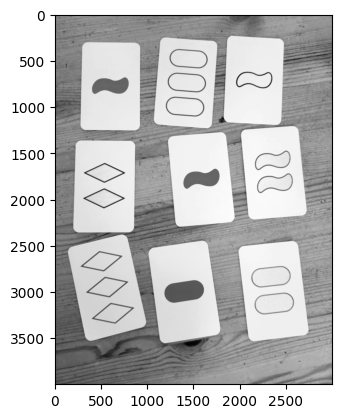

In [63]:
sep_blur = cv2.medianBlur(img, ksize=13)
sep_blur_gray = cv2.cvtColor(sep_blur, cv2.COLOR_BGR2GRAY)
plt.imshow(sep_blur_gray, cmap="gray")

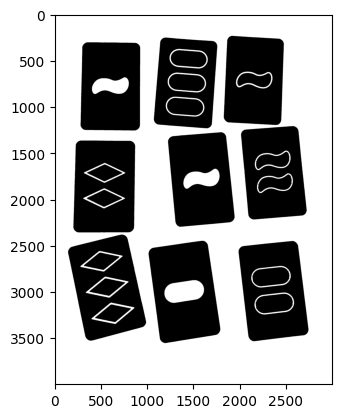

In [64]:
ret, sep_blur_bin = cv2.threshold(sep_blur_gray, 170, 255, cv2.THRESH_BINARY_INV)
plt.imshow(sep_blur_bin, cmap="gray")

In [65]:
# cv2.findContours looks for all contours inside the image and returns a 3-dim vector *contours* 
# (1st-dim: contour, 2nd-3rd-dim: x/y of the contour pixel). 
# an additional vector *hierarchy* contains information about the structure of contours 
contours, hierarchy = cv2.findContours(sep_blur_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

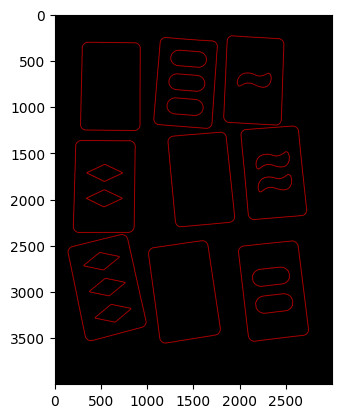

In [66]:
external = np.zeros(img.shape)

for i in range(len(contours)):
    #external contour
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(external, contours, i, 1., 5)

plt.imshow(external, cmap='gray')

In [67]:
# sort the contours according to their area size
index_sort = sorted(range(len(contours)), key=lambda i : cv2.contourArea(contours[i]),reverse=True)

In [68]:
# initialize empty sorted contour and hierarchy lists
cnts_sort = []
hier_sort = []
cnt_is_card = np.zeros(len(contours),dtype=int)    

In [69]:
# Fill empty lists with sorted contour and sorted hierarchy. Now,
# the indices of the contour list still correspond with those of
# the hierarchy list. The hierarchy array can be used to check if
# the contours have parents or not.
for i in index_sort:
    cnts_sort.append(contours[i])
    hier_sort.append(hierarchy[0][i])

In [70]:
# test if the contour corresponds to a game card: 
# here is an example: check if the contour area is within a certain size range.
size = cv2.contourArea(cnts_sort[1]) 
(size < 1000000) and (size > 250000)

True

In [71]:
# extract the 4 corners of a contour (in this example I chose contour #8, 
# which is a playing card) 
peri = cv2.arcLength(cnts_sort[1], True)
approx = cv2.approxPolyDP(cnts_sort[1], 0.075*peri, True)
approx = np.squeeze(approx, axis = 1)
approx

array([[ 735, 2385],
       [ 983, 3337],
       [ 369, 3529],
       [ 142, 2558]], dtype=int32)

In [72]:
# sort the four corners
s = np.sum(approx, axis=1)
topLeft = approx[np.argmin(s)]
bottomRight = approx[np.argmax(s)]
topLeft, bottomRight

(array([ 142, 2558], dtype=int32), array([ 983, 3337], dtype=int32))

In [73]:
d = np.diff(approx, axis = -1)
bottomLeft = approx[np.argmax(d)]
topRight = approx[np.argmin(d)]
topRight, bottomLeft

(array([ 735, 2385], dtype=int32), array([ 369, 3529], dtype=int32))

In [74]:
# get the hieght of the playing card
np.sqrt(np.sum(np.square(topLeft-bottomLeft)))

np.float64(997.1810266947522)

In [75]:
# UpperLeft, UpperRight, LowerRight, LowerLeft
approx_sorted = np.array([topLeft, bottomLeft, bottomRight, topRight], np.int32)
approx_sorted

array([[ 142, 2558],
       [ 369, 3529],
       [ 983, 3337],
       [ 735, 2385]], dtype=int32)

[ 142 2558]
[ 369 3529]
[ 983 3337]
[ 735 2385]


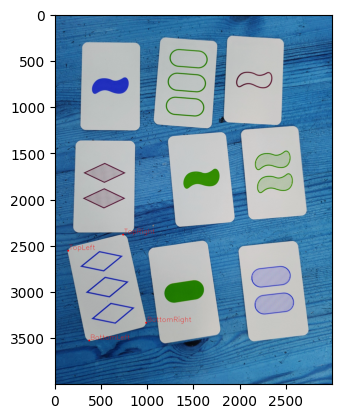

In [76]:
img_w_points = img.copy()
for pts, label in zip(approx_sorted, ['TopLeft', 'BottomLeft', 'BottomRight', 'TopRight']):
    print(pts)
    cv2.circle(img_w_points, pts, radius = 10, color=(255, 0, 0), thickness=-1)
    cv2.putText(img_w_points, label, (pts[0] + 10, pts[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=2.5, color=(255, 0, 0), thickness=2)
plt.imshow(img_w_points)

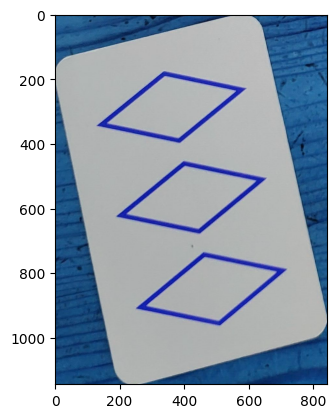

In [77]:
# cut out the playing card from the original imageand save it to tmp_img
#tmp_img = img[np.min(approx_sorted[:,1]):np.max(approx_sorted[:,1]),
#              np.min(approx_sorted[:,0]):np.max(approx_sorted[:,0])]
tmp_img = img[min(topLeft[1], topRight[1]):max(bottomLeft[1], bottomRight[1]),
              min(topLeft[0], bottomLeft[0]):max(topRight[0], bottomRight[0])]
#tmp_img = img[topLeft[1]:bottomRight[1], topLeft[0]:bottomRight[0]]
plt.imshow(tmp_img)

In [78]:
x_len = np.mean(np.diff(np.array([[topLeft[0], topRight[0]],[bottomLeft[0], bottomRight[0]]])))
y_len = np.mean(np.diff(np.array([[topLeft[1], bottomLeft[1]],[topRight[1], bottomRight[1]]])))
x_len / y_len

np.float64(0.6276651066042642)

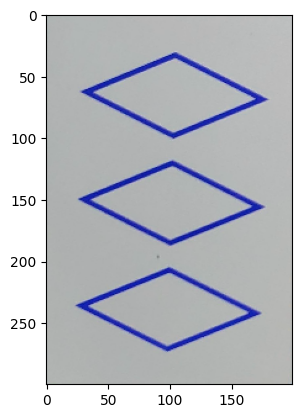

In [79]:
maxWidth=200
maxHeight=300

x_len = np.mean(np.diff(np.array([[topLeft[0], topRight[0]],[bottomLeft[0], bottomRight[0]]])))
y_len = np.mean(np.diff(np.array([[topLeft[1], bottomLeft[1]],[topRight[1], bottomRight[1]]])))
if x_len/y_len > 1.: 
    src = np.array([bottomLeft, topLeft, topRight, bottomRight], np.float32)
else:
    src = np.array([topLeft, topRight, bottomRight, bottomLeft], np.float32)
dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
warped_img = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
plt.imshow(warped_img)

In [80]:
# Determine which of the contours are cards by applying the
# following criteria: 1) Smaller area than the maximum card size,
# 2), bigger area than the minimum card size, 3) have no parents,
# and 4) have four corners

boundingBox = []
Card = []
maxWidth = 200
maxHeight = 300

for i in range(len(cnts_sort)):
    size = cv2.contourArea(cnts_sort[i])
    peri = cv2.arcLength(cnts_sort[i],True)
    approx = cv2.approxPolyDP(cnts_sort[i],0.075*peri,True)
    approx = np.squeeze(approx, axis = 1)
        
    if ((size < 1000000) and (size > 250000)
        and (hier_sort[i][3] != -1) and (len(approx) == 4)):
        cnt_is_card[i] = 1
        s = np.sum(approx, axis=1)
        d = np.diff(approx, axis = -1)
        
        topLeft = approx[np.argmin(s)]
        bottomRight = approx[np.argmax(s)]
        topRight = approx[np.argmin(d)]
        bottomLeft = approx[np.argmax(d)]
        
        x_len = np.mean(np.diff(np.array([[topLeft[0], topRight[0]],[bottomLeft[0], bottomRight[0]]])))
        y_len = np.mean(np.diff(np.array([[topLeft[1], bottomLeft[1]],[topRight[1], bottomRight[1]]])))
        
        if x_len/y_len > 1.: 
            src = np.array([bottomLeft, topLeft, topRight, bottomRight], np.float32)
        else:
            src = np.array([topLeft, topRight, bottomRight, bottomLeft], np.float32)
        dst = np.array([[0,0],[maxWidth-1,0],[maxWidth-1,maxHeight-1],[0, maxHeight-1]], np.float32)
        M = cv2.getPerspectiveTransform(src, dst)
        warped_img = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
        Card.append(warped_img[10:290,10:190])
        

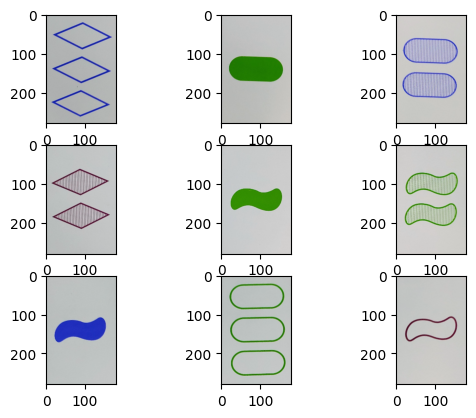

In [81]:
x, y = 3, 3
figure, axis = plt.subplots(y, x)
for i in range(y):
    for j in range(x):
        axis[i, j].imshow(Card[i*x+j])
plt.show()

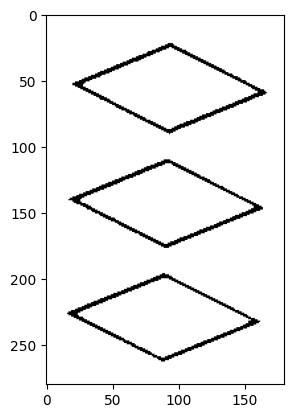

In [90]:
card_n = Card[0]

card_0_hsv = cv2.cvtColor(card_n, cv2.COLOR_RGB2HLS)
card_0_hue, _, card_0_gray = cv2.split(card_0_hsv)
#card_0_gray = cv2.cvtColor(card_n, cv2.COLOR_BGR2GRAY)
_, card_0_bin = cv2.threshold(card_0_gray, 150, 255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(card_0_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(card_0_bin, cmap='gray')


In [91]:
M = cv2.moments(contours[0])

In [92]:
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])

cv2.countNonZero(card_0_bin[cy-10:cy+10, cx-20:cx+20])


800

In [93]:
card_0_masked = cv2.bitwise_and(card_0_hsv, card_0_hsv, mask = card_0_bin)
card_0_hist = cv2.calcHist([card_0_hsv], channels = [0], mask = card_0_bin, histSize =[32], ranges  = [0, 255])
np.argmax(card_0_hist)

np.int64(11)

In [94]:
class ShapeDetector:
    def __init__(self, card):
        self.card_hls = cv2.cvtColor(card, cv2.COLOR_RGB2HLS)
        self.card_hue, self.card_gray, _ = cv2.split(self.card_hls)
        #self.card_0_gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)
        _, self.card_bin = cv2.threshold(self.card_gray, 160, 255, cv2.THRESH_BINARY_INV)
        self.contours, self.hierarchy = cv2.findContours(self.card_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.card_masked = cv2.bitwise_and(self.card_hls, self.card_hls, mask = self.card_bin)
        self.card_hist = cv2.calcHist([self.card_hls], channels = [0], mask = self.card_bin, histSize =[32], ranges  = [0, 255])
        c_val = np.argmax(self.card_hist)
    
    def guess_shape(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        epsilon = 0.02*cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,epsilon,True)
        M = cv2.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])  
        if not cv2.isContourConvex(approx): 
            return "schlange"
        elif len(approx) == 4:
            return "diamant"
        else: 
            return "pille"

    def guess_shade(self, c):
        epsilon = 0.02*cv2.arcLength(c,True)
        approx = cv2.approxPolyDP(c,epsilon,True)
        M = cv2.moments(c)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        n_white = cv2.countNonZero(self.card_bin[cy-10:cy+10, cx-20:cx+20])
        if n_white < 10: 
            return "leer"
        elif n_white < 500:
            return "halb"
        else: 
            return "voll"

    def guess_color(self, c):
        c_val = np.argmax(self.card_hist)
        if c_val < 10: 
            return "gruen"
        elif c_val < 18: 
            return "blau"
        else:
            return "rot"

        
    def detect(self):

        result = ""
        for c in contours: 
            if cv2.contourArea(c) > 800: 
                # return the name of the shape
                result = result + self.guess_color(c) + " " + self.guess_shade(c) + " " + self.guess_shape(c) + "\n"

        
        return result

In [95]:
for i, card_i in enumerate(Card):
    print(f'Card {i}')
    sd = ShapeDetector(card_i)
    shape = sd.detect()
    print(shape)
    print()

Card 0
blau leer diamant


Card 1
gruen voll diamant


Card 2
blau leer diamant


Card 3
rot leer diamant


Card 4
gruen voll diamant


Card 5
gruen leer diamant


Card 6
blau voll diamant


Card 7
gruen leer diamant


Card 8
rot leer diamant


